## Задание 1

Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [597]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import model_selection
from sklearn.datasets import load_diabetes

import numpy as np

In [598]:
X, y = load_diabetes(return_X_y=True)

In [599]:
X.shape

(442, 10)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [600]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * predict([x], alg)[0]  for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [601]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [602]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [603]:
def gb_fit(n_trees, max_depth, min_q, n_elem, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree(X_train, y_train, max_depth, min_q, n_elem)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target), max_depth, min_q, n_elem)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [605]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int((len_sample)/3)
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [606]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [607]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [608]:
# Расчет дисперсии
def disp(labels):
    return labels.var()

In [609]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * disp(left_labels) - (1 - p) * disp(right_labels)

In [610]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [611]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = disp(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной n_features/3
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [612]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=np.inf, min_q=0.0, n_elem=1):
    quality, t, index = find_best_split(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality <= min_q or max_depth <= 0 or labels.size <= n_elem:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    max_depth -= 1
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, min_q, n_elem)
    false_branch = build_tree(false_data, false_labels, max_depth, min_q, n_elem)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [613]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [614]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [615]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [616]:
# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [617]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [624]:
# Число деревьев в ансамбле
n_trees = [10, 30, 50, 80, 100, 120, 150, 200]

# для простоты примем коэффициенты равными 1
coefs = []
for trees in n_trees:
    coefs.append([1] * tree)

# Максимальная глубина деревьев
max_depth = [3, 4, 5, 10]

# Минимальное качество
min_q = 0.00

# Число элементов в листе
n_elem = 2

# Шаг
eta = 0.01

In [625]:
trees_variants = []
for i in range(len(n_trees)):
    for md in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees[i], md, min_q, 
                                                  n_elem, X_train, X_test, 
                                                  y_train, y_test, coefs[i], eta)
        
        trees_variants.append({
            'n_trees': n_trees[i],
            'max_depth': md,
            'coefs': coefs[i],
            'trees': trees,
            'train_errors': train_errors,
            'test_errors': test_errors,
        })

In [637]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth, n_trees):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    mse_train = mean_squared_error(y_train, train_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse_train}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    mse_test = mean_squared_error(y_test, test_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse_test}')
    
    return n_trees, max_depth, mse_train, mse_test

In [642]:
data_map = []
for trees in trees_variants:
    print('')
    data_map.append(evaluate_alg(X_train, X_test, y_train, 
                             y_test, trees['trees'], trees['coefs'], 
                             eta, trees['max_depth'], trees['n_trees']))
data_map = np.array(data_map)


Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 25772.334246184117
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 23292.865912715177

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.01 на тренировочной выборке: 25208.062828972557
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.01 на тестовой выборке: 22907.06880187163

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 25130.907301416963
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 22899.37403116549

Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тренировочной выборке: 24699.234657844114
Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 22651.033227334316

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 19174.970990168877
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тестово

In [652]:
def get_error_plot(param, train_err, test_err, xlabel):
    plt.title(xlabel)
    plt.xlabel(xlabel)
    plt.ylabel('MSE')
    plt.plot(param, train_err, label='train error')
    plt.plot(param, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [670]:
common_depth = {}
for m in max_depth:
    common_depth[m] = []
    for row in data_map:
        if row[1] == m:
            common_depth[m].append(row)

common_trees = {}
for t in n_trees:
    common_trees[t] = []
    for row in data_map:
        if row[0] == t:
            common_trees[t].append(row)
            

Depth 3


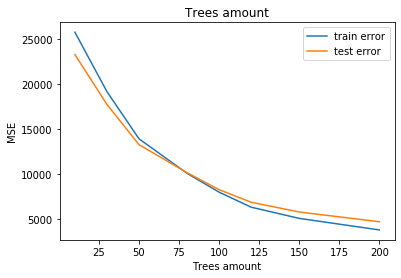

Depth 4


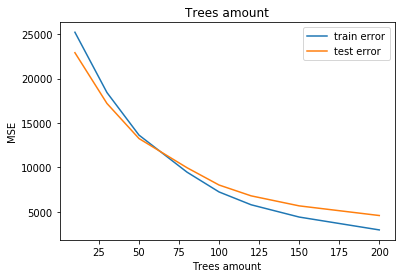

Depth 5


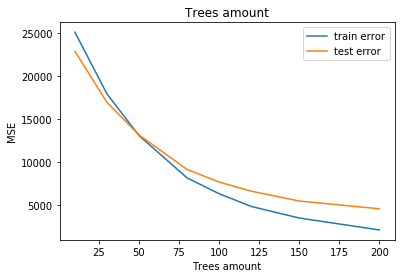

Depth 10


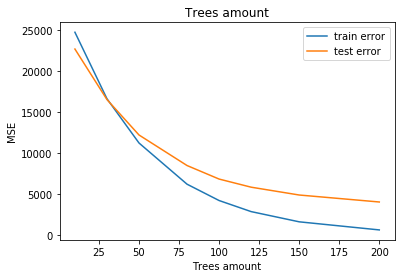

In [674]:
for k, v in common_depth.items():
    print('Depth', k)
    r = np.array(v)
    get_error_plot(r[:,0], r[:,2], r[:,3], 'Trees amount')

Trees amount 10


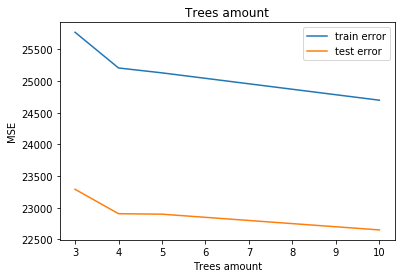

Trees amount 30


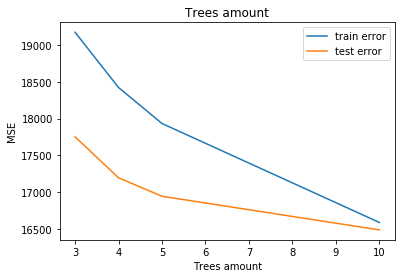

Trees amount 50


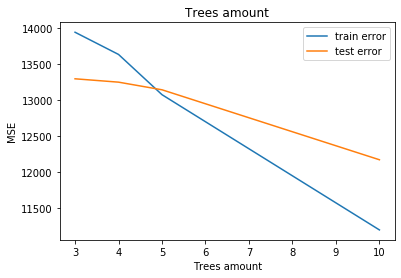

Trees amount 80


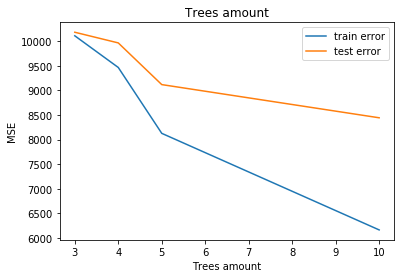

Trees amount 100


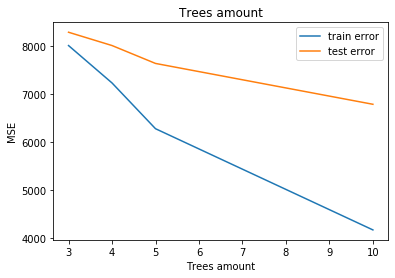

Trees amount 120


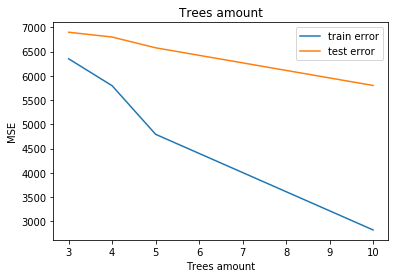

Trees amount 150


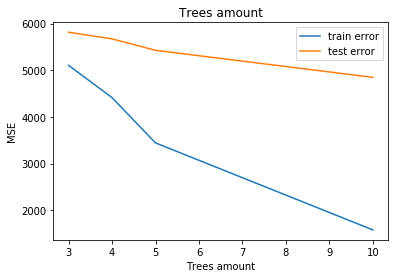

Trees amount 200


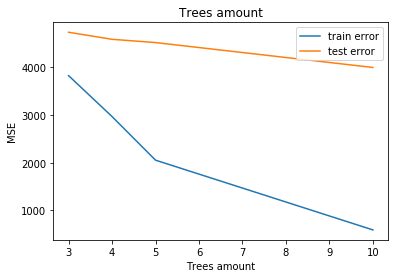

In [676]:
for k, v in common_trees.items():
    print('Trees amount', k)
    r = np.array(v)
    get_error_plot(r[:,1], r[:,2], r[:,3], 'Trees amount')

## Задание 2

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.

Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [677]:
def gb_fit(n_trees, max_depth, min_q, n_elem, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    batches = get_batches(X_train, y_train)
    n = 0
    
    for i in range(n_trees):
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        
        batch_X_train = batches[n][0]
        batch_y_train = batches[n][1]
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree(batch_X_train, batch_y_train, max_depth, min_q, n_elem)

            train_errors.append(mean_squared_error(batch_y_train, gb_predict(batch_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(batch_X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(batch_X_train, bias(batch_y_train, target), max_depth, min_q, n_elem)
            
            train_errors.append(mean_squared_error(batch_y_train, gb_predict(batch_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        n += 1
        if n > (len(batches) - 1):
            n = 0
    return trees, train_errors, test_errors

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [678]:
random.seed(42)

def get_batches(data, labels):
    n_samples = data.shape[0]
    n_batches = 3
    N = int(data.shape[0]/n_batches)
    batches = []
    
    for i in range(n_batches):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx = np.zeros(labels.shape).astype(int)
        
        for j in range(N):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_idx[j] = sample_index
        batches.append((b_data, b_labels, b_idx))
        
    return batches

In [682]:
# Число деревьев в ансамбле
n_trees = [10, 30, 50, 80, 100, 120, 150, 200]

# для простоты примем коэффициенты равными 1
coefs = []
for trees in n_trees:
    coefs.append([1] * tree)

# Максимальная глубина деревьев
max_depth = [3, 4, 5, 10]

# Минимальное качество
min_q = 0.00

# Число элементов в листе
n_elem = 2

# Шаг
eta = 0.01

In [ ]:
trees_variants = []
for i in range(len(n_trees)):
    for md in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees[i], md, min_q, 
                                                  n_elem, X_train, X_test, 
                                                  y_train, y_test, coefs[i], eta)
        
        trees_variants.append({
            'n_trees': n_trees[i],
            'max_depth': md,
            'coefs': coefs[i],
            'trees': trees,
            'train_errors': train_errors,
            'test_errors': test_errors,
        })

In [ ]:
data_map = []
for trees in trees_variants:
    print('')
    data_map.append(evaluate_alg(X_train, X_test, y_train, 
                             y_test, trees['trees'], trees['coefs'], 
                             eta, trees['max_depth'], trees['n_trees']))
data_map = np.array(data_map)